In [1]:
# imports libraries
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [33]:
# read dataset and show the first 5 rows
df = pd.read_csv('../dataset/full_COA.csv.' , index_col='Time',parse_dates=True)
df.head()

,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,
2012-01-01 01:00:00,5986.0,13.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 02:00:00,5547.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 03:00:00,5233.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 04:00:00,5150.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2012-01-01 05:00:00,5235.0,11.98,2012,1,1,1,0,0,0,0,0,0,1


In [34]:
# show last five rows
df.tail()

,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,
2017-12-31 19:00:00,9495.0,18.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 20:00:00,9365.0,16.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 21:00:00,9250.0,15.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 22:00:00,8931.0,14.98,2017,4,12,31,0,0,0,0,0,0,1
2017-12-31 23:00:00,8679.0,12.98,2017,4,12,31,0,0,0,0,0,0,1


In [35]:
df_l = df

In [36]:
# show length of dataframe
len(df_l)

52607

In [37]:
# assain frequebcy to hourly
df_l.index.freq = '1H'

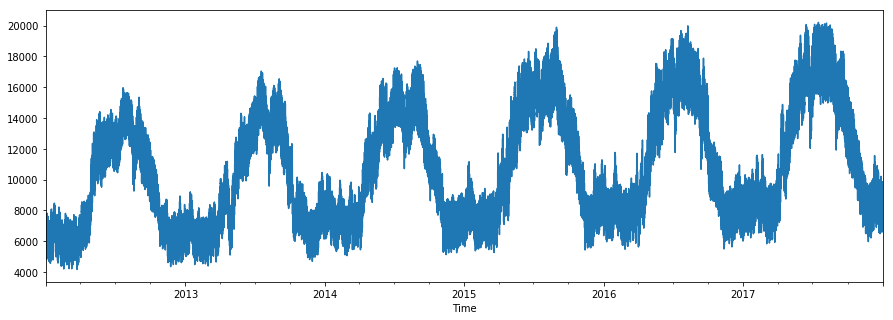

In [38]:
# plotting daily data set
pd.plotting.register_matplotlib_converters()# this code used to resolve some failure prophet have with pandas
df_l.COA.plot(figsize=(15,5)).autoscale(axis='x',tight=True)

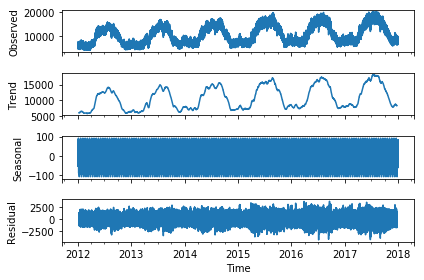

In [39]:
# seasonal decompose for megawatts 
seasonal_decompose(df_l.COA , freq=365).plot();

In [40]:
# autocorrelation plot
plot_acf(df_l.COA , lags=20);

In [41]:
# partial autocorrelaton plot
plot_pacf(df_l.COA , lags=20);

In [42]:
# define a function to do the Dickey-Fuller Test

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [43]:
# Dickey-Fuller Test for megawatts
adf_test(df_l.COA)

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.208369
p-value                     0.019505
# lags used                58.000000
# observations          52548.000000
critical value (1%)        -3.430474
critical value (5%)        -2.861595
critical value (10%)       -2.566799
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [44]:
# reset index to prepare data frame for prophet
df_l = df_l.reset_index()

In [45]:
# rename columns to prepare it for prophet
df_l = df_l.rename(columns = {'Time':'ds',
                      'COA':'y'})

In [46]:
# define a length to split, split last year
l_split = len(df_l[df_l.ds >= '2017-01-01 00:00:00'])

In [47]:
# split by pre defined length
train = df_l.iloc[:(len(df_l)-l_split)]
test = df_l.iloc[(len(df_l)-l_split):]

In [48]:
model = Prophet(seasonality_mode='multiplicative')
model.add_regressor('temp')
model.add_regressor('year')
model.add_regressor('quarter')
model.add_regressor('month')
model.add_regressor('day')
model.add_regressor('weekday_0')
model.add_regressor('weekday_1')
model.add_regressor('weekday_2')
model.add_regressor('weekday_3')
model.add_regressor('weekday_4')
model.add_regressor('weekday_5')
model.add_regressor('weekday_6')
model.fit(train)

In [49]:
# make data frame to hold the prediction
future = model.make_future_dataframe(periods=24 , freq='H')

In [50]:
# make prediction on the data frame made 
forecast = model.predict(test.drop(columns=['y']))

In [51]:
# check predictionn columns
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'daily', 'daily_lower', 'daily_upper', 'day', 'day_lower', 'day_upper',
       'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'month', 'month_lower',
       'month_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'quarter', 'quarter_lower',
       'quarter_upper', 'temp', 'temp_lower', 'temp_upper', 'weekday_0',
       'weekday_0_lower', 'weekday_0_upper', 'weekday_1', 'weekday_1_lower',
       'weekday_1_upper', 'weekday_2', 'weekday_2_lower', 'weekday_2_upper',
       'weekday_3', 'weekday_3_lower', 'weekday_3_upper', 'weekday_4',
       'weekday_4_lower', 'weekday_4_upper', 'weekday_5', 'weekday_5_lower',
       'weekday_5_upper', 'weekday_6', 'weekday_6_lower', 'weekday_6_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'year', 'year_lower',
       'year_up

In [52]:
# show last 5 rows of forecast
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
8755,2017-12-31 19:00:00,4931.161247,661.029717,18979.498492,476.104390,9182.854358,0.176918,0.176918,0.176918,-0.000192,...,-0.056146,-0.056146,-0.056146,-0.482249,-0.482249,-0.482249,0.0,0.0,0.0,10103.896212
8756,2017-12-31 20:00:00,4931.182806,675.506721,18723.462487,474.966578,9183.308468,0.193841,0.193841,0.193841,-0.000192,...,-0.056146,-0.056146,-0.056146,-0.482230,-0.482230,-0.482230,0.0,0.0,0.0,10020.743744
8757,2017-12-31 21:00:00,4931.204364,913.301491,18543.914754,473.828765,9183.762578,0.185337,0.185337,0.185337,-0.000192,...,-0.056146,-0.056146,-0.056146,-0.482210,-0.482210,-0.482210,0.0,0.0,0.0,9896.740061
8758,2017-12-31 22:00:00,4931.225923,547.726709,18013.356238,472.690953,9184.216689,0.146094,0.146094,0.146094,-0.000192,...,-0.056146,-0.056146,-0.056146,-0.482190,-0.482190,-0.482190,0.0,0.0,0.0,9621.161697
8759,2017-12-31 23:00:00,4931.247482,814.467170,17283.632382,471.553140,9184.670799,0.086587,0.086587,0.086587,-0.000192,...,-0.056146,-0.056146,-0.056146,-0.482171,-0.482171,-0.482171,0.0,0.0,0.0,9161.122003


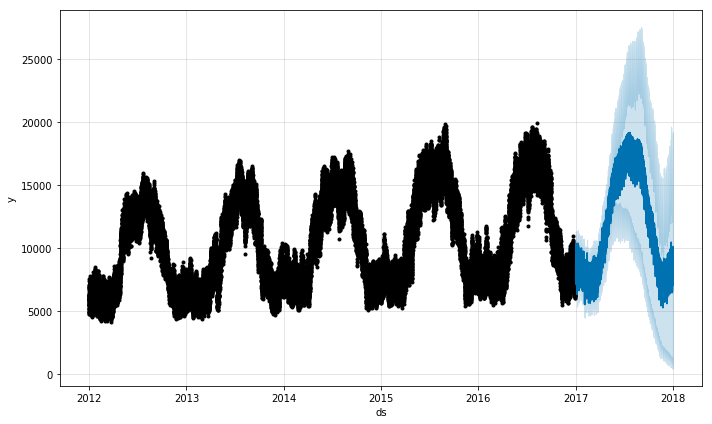

In [53]:
# plotting forcast
model.plot(forecast);

In [54]:
# make a seperate data set for prediction only
predictions = forecast[['ds','yhat']][forecast.ds >='2017']

In [55]:
# set time as index
predictions = predictions.set_index('ds')
test = test.set_index('ds')

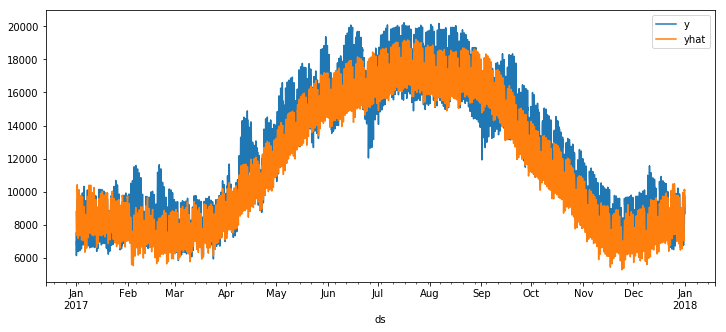

In [56]:
# plot test vs prediction
test.y.plot(legend=True,figsize=(12,5))
predictions.yhat.plot(legend=True)

In [57]:
# calculate rmse
rmse(test.y,predictions.yhat)

1034.6029688789902

In [58]:
# calculate r2 score
r2_score(test.y , predictions.yhat)

0.9338387475503872